# Train Code

## 1. Download dataset and import necessary libraries

In [1]:
! gdown "https://drive.google.com/uc?id=1bLxeZUA6Xsk7V6ktU4jGINm1O7hq2hHJ&confirm=t"
! unzip -o -q tabular-playground-series-aug-2022.zip

Downloading...
From: https://drive.google.com/uc?id=1bLxeZUA6Xsk7V6ktU4jGINm1O7hq2hHJ&confirm=t
To: /home/poyehchen/Courses/introduction-to-machine-learning-2022/final/intro-to-ml-2022-final/tabular-playground-series-aug-2022.zip
100%|██████████████████████████████████████| 2.38M/2.38M [00:00<00:00, 58.9MB/s]


In [2]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Set file paths

In [3]:
BASE = os.getcwd()
train = pd.read_csv(BASE + "/train.csv")

## 3. View data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [5]:
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


Since we saw some missing data (`NaN` elements), we now need to fill them...

Now we plot the histogram to see if any feature needs to be normalized

In [6]:
fs = [f for f in train.columns if f.startswith("measurement") or f == "loading" or f =="failure"]

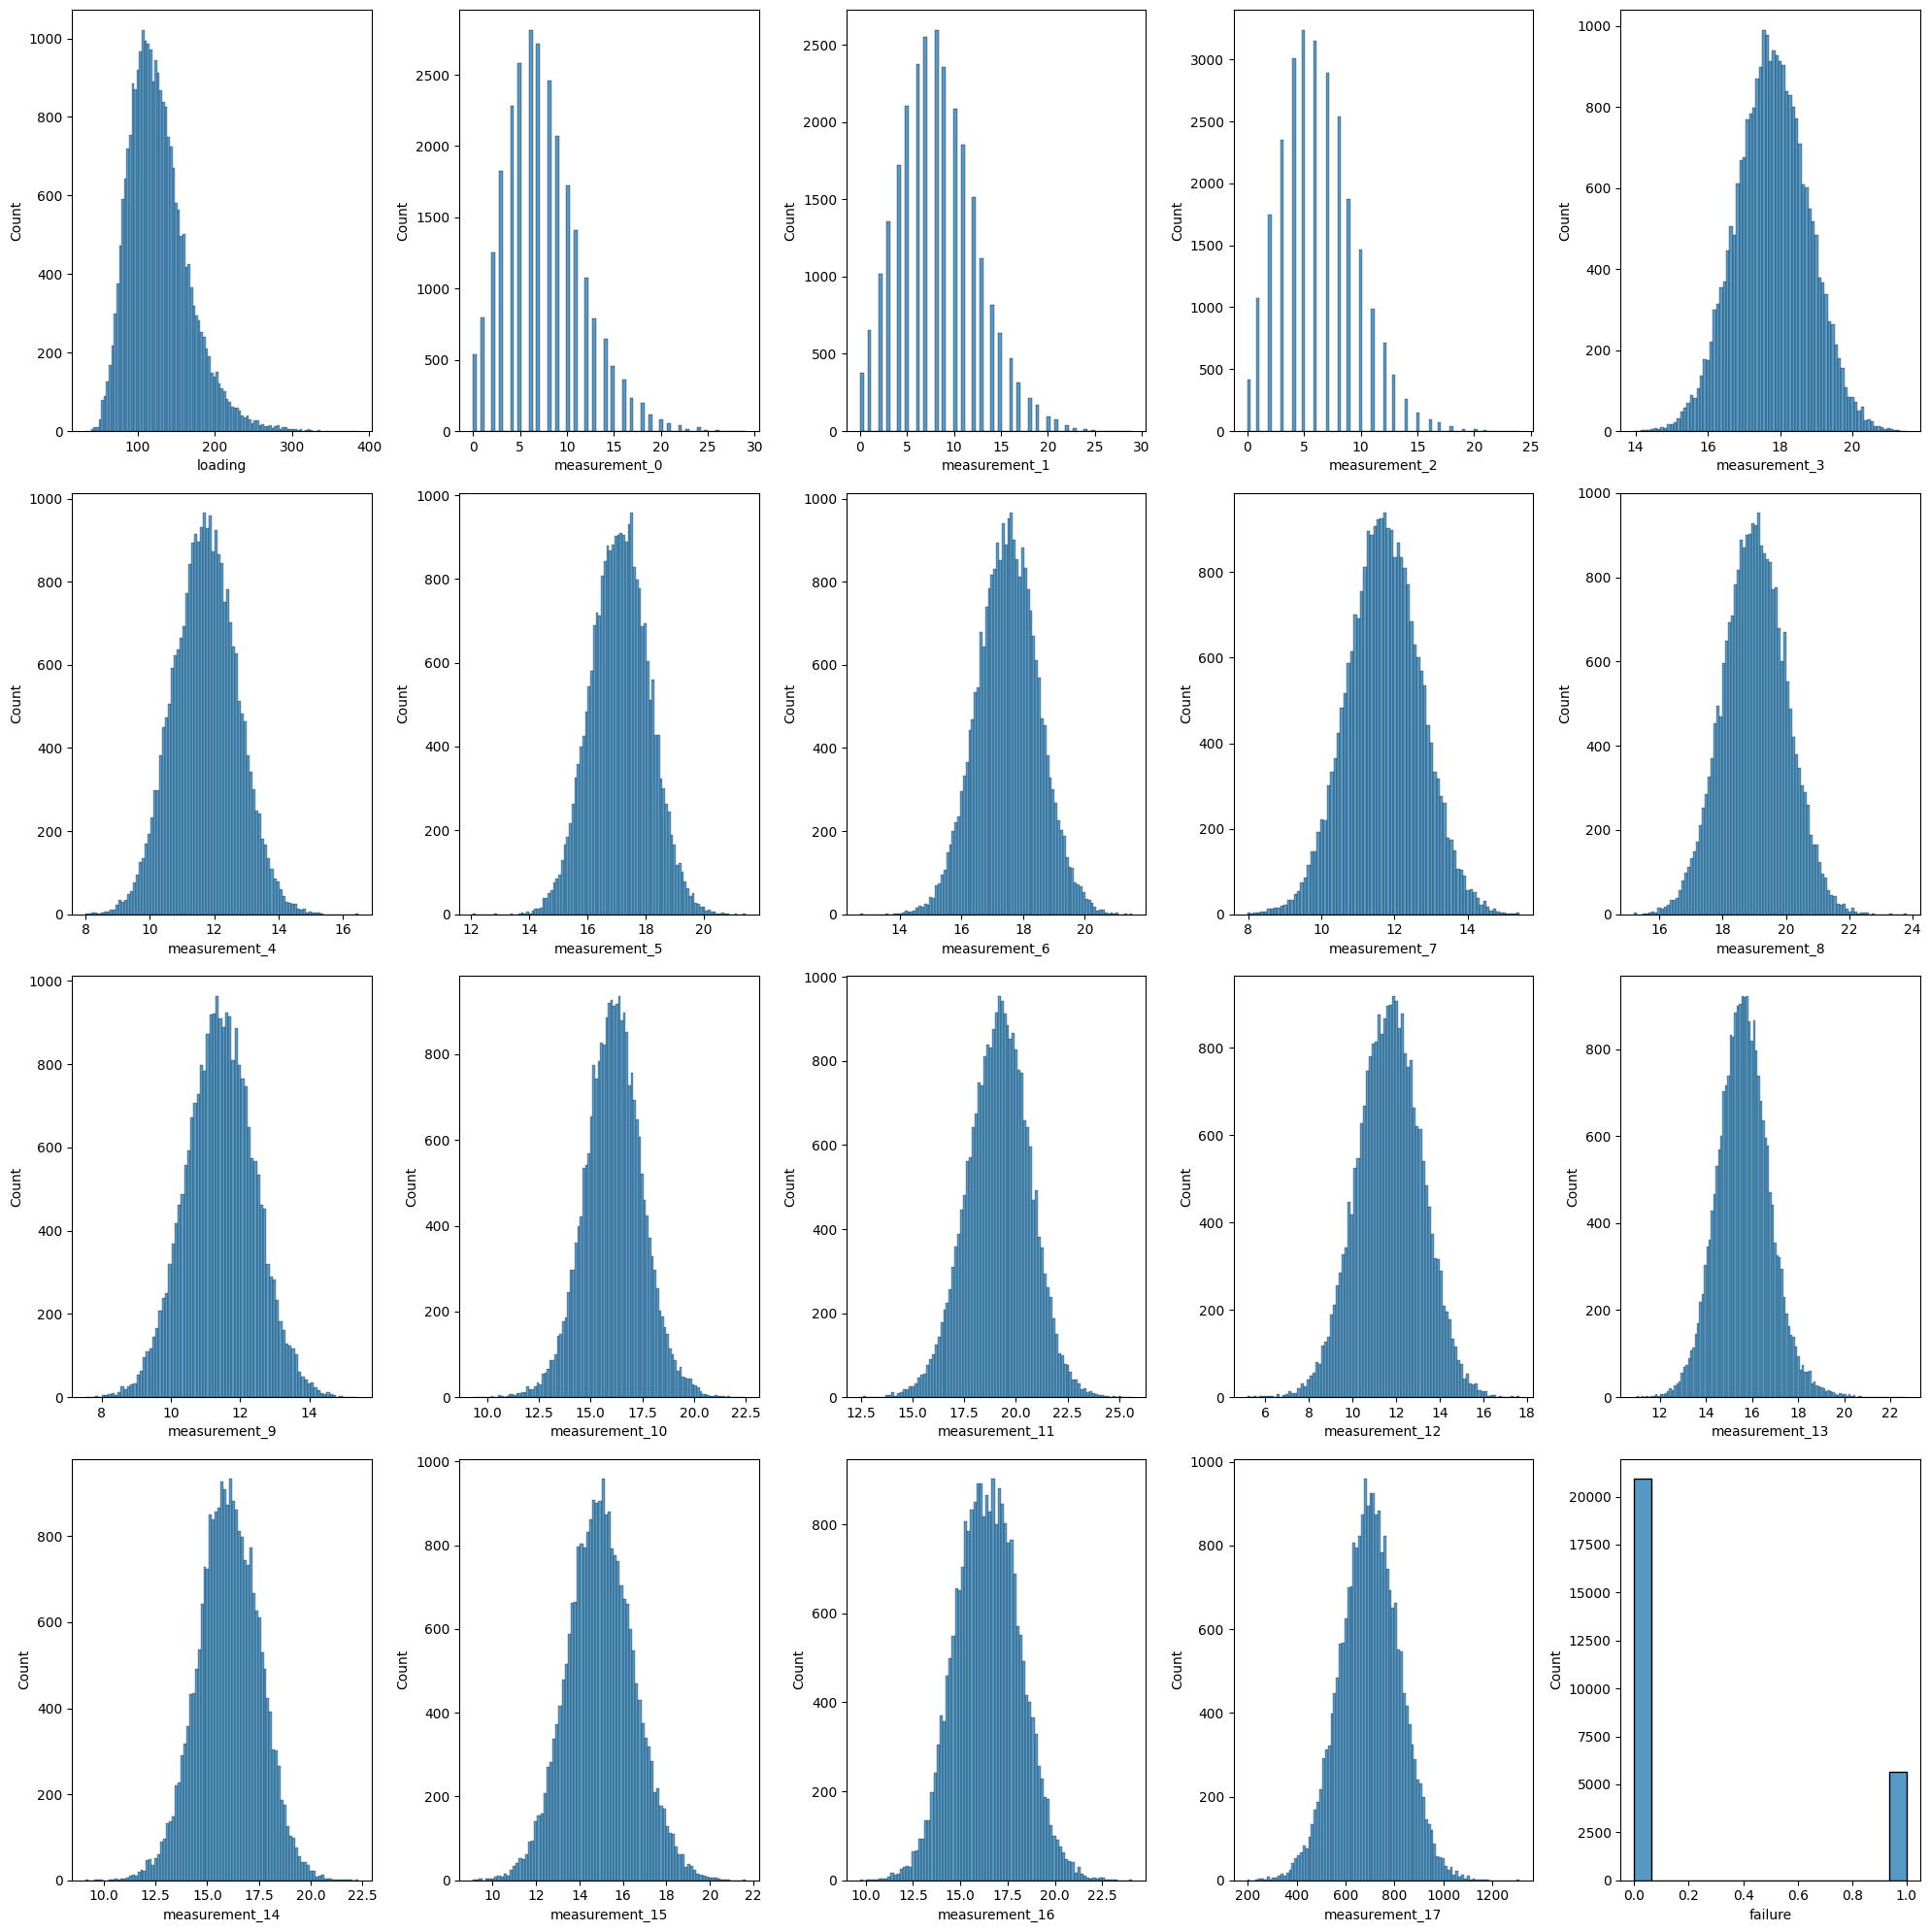

In [7]:
plt.figure(figsize=(20, 20))

acc = 1
for f in fs:
    plt.subplot(4, 5, acc)
    sns.histplot(train[f])
    acc += 1

plt.tight_layout()
plt.show()

It seems like `loading` needs to be normalized, as the data is not centered properly. `measurement_0`, `measurement_1`, `measurment_2` is
pretty discrete, we don't need to normalize them.

## 4. Preprocess

In [8]:
data = train

Use `np.log1p` to normalize `data["loading"]`.

In [9]:
data["loading"] = np.log1p(data["loading"])

<AxesSubplot: xlabel='loading', ylabel='Count'>

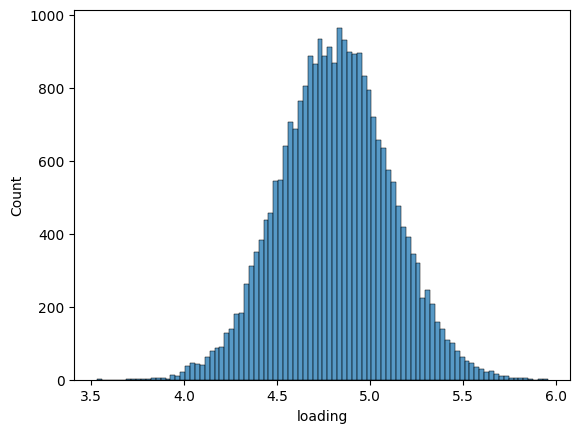

In [10]:
sns.histplot(data["loading"])

Select `loading` and `measurement_*` as all features.

In [11]:
feature = [f for f in data.columns if f.startswith("measurement") or f == "loading"]

In [12]:
print(feature)

['loading', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


4. Use `KNNImputer` to fill the columns.

In [13]:
for code in data.product_code.unique():
    model = KNNImputer(n_neighbors=5)
    print(f"KNN imputing code {code}")
    data.loc[data.product_code==code, feature] = model.fit_transform(data.loc[data.product_code==code, feature])

KNN imputing code A
KNN imputing code B
KNN imputing code C
KNN imputing code D
KNN imputing code E


## 5. Train

1. Split data

In [14]:
train = data
X = train.drop(['failure'], axis=1)
y = train['failure'].astype(int)

2. Define `scale_data` that uses `StandardScaler` to standarize features.

In [15]:
def scale_data(data, feats):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[feats])
    new_data = data.copy()
    new_data[feats] = scaled_data
    assert len(data) == len(new_data)
    return new_data

2. Define `train` that uses selected features to train.
    - Uses `StartifiedKFold` to split data into train/validation sets.
    - Uses `LogisticRegression` as classifier model.
    - Train model for different selected features. Each selected feture will save 5 models, 1 for each iteration.

In [16]:
models = dict()

def train_model(cur, select_feature):
    lr_oof_1 = np.zeros(len(train))
    lr_oof_2 = np.zeros(len(train))
    lr_auc = 0
    lr_acc = 0
    models[cur] = list()
    importance_list = []

    # Use 0 as seed to reproduce
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold:", fold_idx+1)
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        x_train = scale_data(x_train, select_feature)
        x_val = scale_data(x_val, select_feature)
    
        model = LogisticRegression(max_iter=1000, C=0.0001, penalty='l2', solver='newton-cg')
        model.fit(x_train[select_feature], y_train)
  
        val_preds = model.predict_proba(x_val[select_feature])[:, 1]
        y_preds = model.predict(x_val[select_feature])
        lr_auc += roc_auc_score(y_val, val_preds) / 5
        lr_acc += accuracy_score(y_val, y_preds) / 5
        lr_oof_1[val_idx] = val_preds
        lr_oof_2[val_idx] = y_preds
        models[cur].append(model)
        importance_list.append(model.coef_.ravel())

    print(f"Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}")
    print(f"OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}")
    importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = x_train[select_feature].columns
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
    plt.barh(importance_df.index, importance_df['mean'])
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('LogisticRegression feature importances')
    plt.show()

3. Test train on all features (`loading` and `measurement_*`).

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.58887, Average acc = 0.78739
OOF auc = 0.58868, OOF acc = 0.78739


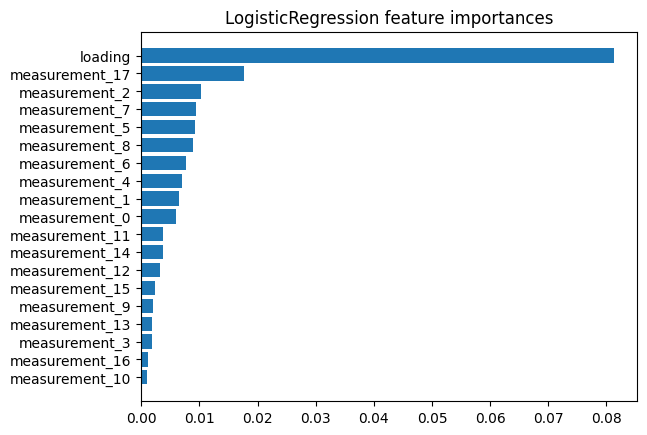

In [17]:
train_model('test', feature)

We can see that `loading` is most significant, followed by `measurment_17`, then `measurement_2`, `measurement_7`, `measurement_5`, `measurement_8`.

We will use them to train.

The training is simple: pick `loading`, `measurement_17` and one of `measurment_17`, then `measurement_2`, `measurement_7`, `measurement_5`, `measurement_8`, like the following shows.

The influence on final predict will be: `fs0` * 0.4, `fs1` * 0.3, `fs2` * 0.2, `fs1` * 0.1.
`fs` denotes "Feature Set".

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.59015, Average acc = 0.78739
OOF auc = 0.59006, OOF acc = 0.78739


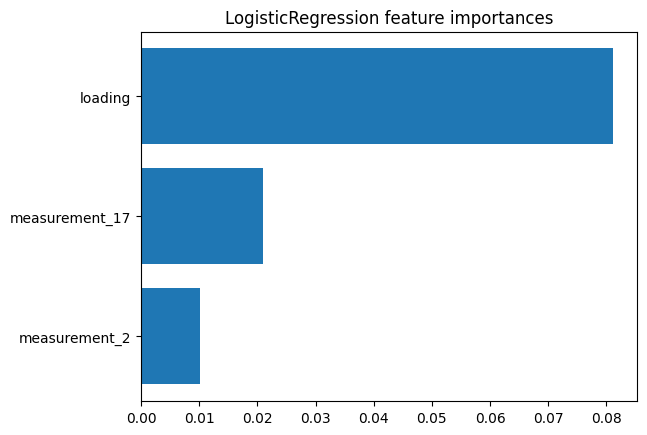

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.58981, Average acc = 0.78739
OOF auc = 0.58977, OOF acc = 0.78739


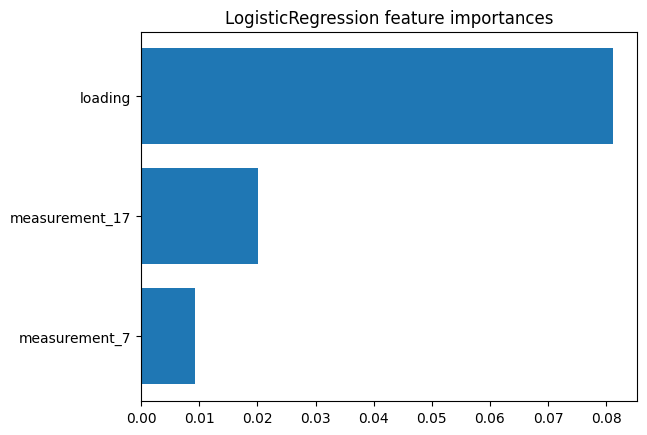

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.58938, Average acc = 0.78739
OOF auc = 0.58933, OOF acc = 0.78739


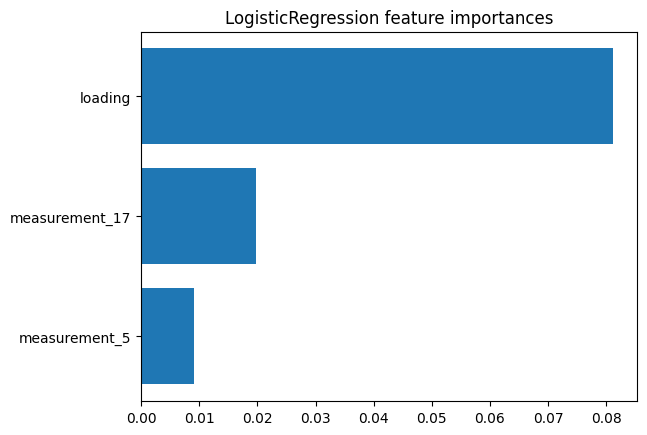

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average auc = 0.58943, Average acc = 0.78739
OOF auc = 0.58938, OOF acc = 0.78739


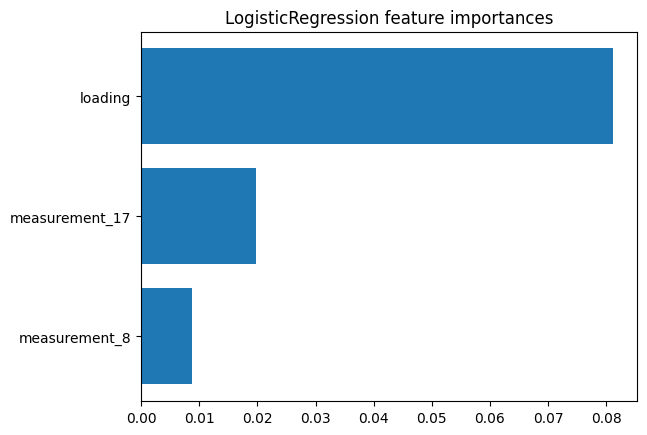

In [20]:
train_model('fs0', ['measurement_2', 'loading', 'measurement_17'])
train_model('fs1', ['measurement_7', 'loading', 'measurement_17'])
train_model('fs2', ['measurement_5', 'loading', 'measurement_17'])
train_model('fs3', ['measurement_8', 'loading', 'measurement_17'])

In [21]:
joblib.dump(models, "trained_model")

['trained_model']